In [172]:
import numpy as np
import datetime
from datetime import date, timedelta
import datetime
import pandas as pd
import math
import itertools
import time
import netCDF4 as nc
import xarray as xr
import cv2
from scipy.ndimage import gaussian_filter
import matplotlib.pyplot as plt

In [148]:
x = np.array([[1.1,2,3,4],[2,np.nan, 5, 6], [np.nan, 3, 4, 5]])

In [149]:
x

array([[1.1, 2. , 3. , 4. ],
       [2. , nan, 5. , 6. ],
       [nan, 3. , 4. , 5. ]])

In [150]:
x[x == 3] = np.nan

In [151]:
x

array([[1.1, 2. , nan, 4. ],
       [2. , nan, 5. , 6. ],
       [nan, nan, 4. , 5. ]])

In [158]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    current_path = os.getcwd()
    data_folder = os.path.join(current_path,"../data")
    
    nc_path = os.path.join(data_folder, data)
    ds = nc.Dataset(nc_path)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    df = df.drop(['depth'], axis=1, errors='ignore') #drop the column 'depth' if exists: only exists in reanalysis
    
    #if MUR data, rename columns and convert temperature to Celsius (the data must be saved as 'mur...nc')
    if data.startswith('mur'):
        df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
        df['thetao'] = df['thetao']-273.15   
        
    
    return df

In [159]:
df_ex = get_data('sst_20220615.nc')

In [162]:
df_ex

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2022-06-15 09:00:00,292.756989
1,35.0,-18.990000,2022-06-15 09:00:00,292.744995
2,35.0,-18.980000,2022-06-15 09:00:00,292.733002
3,35.0,-18.969999,2022-06-15 09:00:00,292.721985
4,35.0,-18.959999,2022-06-15 09:00:00,292.709991
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-15 09:00:00,291.488007
1402397,45.0,-5.030000,2022-06-15 09:00:00,291.488983
1402398,45.0,-5.020000,2022-06-15 09:00:00,291.489990
1402399,45.0,-5.010000,2022-06-15 09:00:00,291.489990


In [181]:


# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst = df_ex.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
#Convert Temperature values to uint8 format with values in the range of 0-255
sst_final = ((sst - np.nanmin(sst)) * (1/(np.nanmax(sst) - np.nanmin(sst)) * 255)).astype('uint8')
sst_final = np.flipud(sst_final)   #flipud -> Reverse the order of elements along axis 0 (up/down).
#in case we want to apply a gaussian filter with a certain sigma value (by default is 0)
sst_final = gaussian_filter(sst_final, sigma=5)   


#apply the canny algorithm and plot the image with the edges
canny = cv2.Canny(sst_final, 120, 220, apertureSize=5, L2gradient=False)

#Apply a mask for the continental zone:
mask = np.isnan(np.flipud(sst))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_front =np.ma.masked_where(mask_dilated==255, canny)   #Mask an array where a condition is True

canny_front[canny_front == 255] = 1

#canny_front = np.flipud(canny_front) 



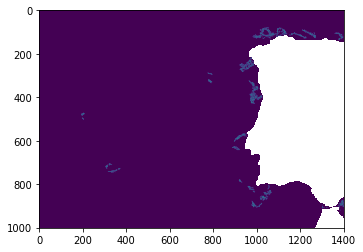

In [182]:
plt.imshow(canny_front)

In [183]:
canny_front.max()

1